In [1]:
import pymc

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

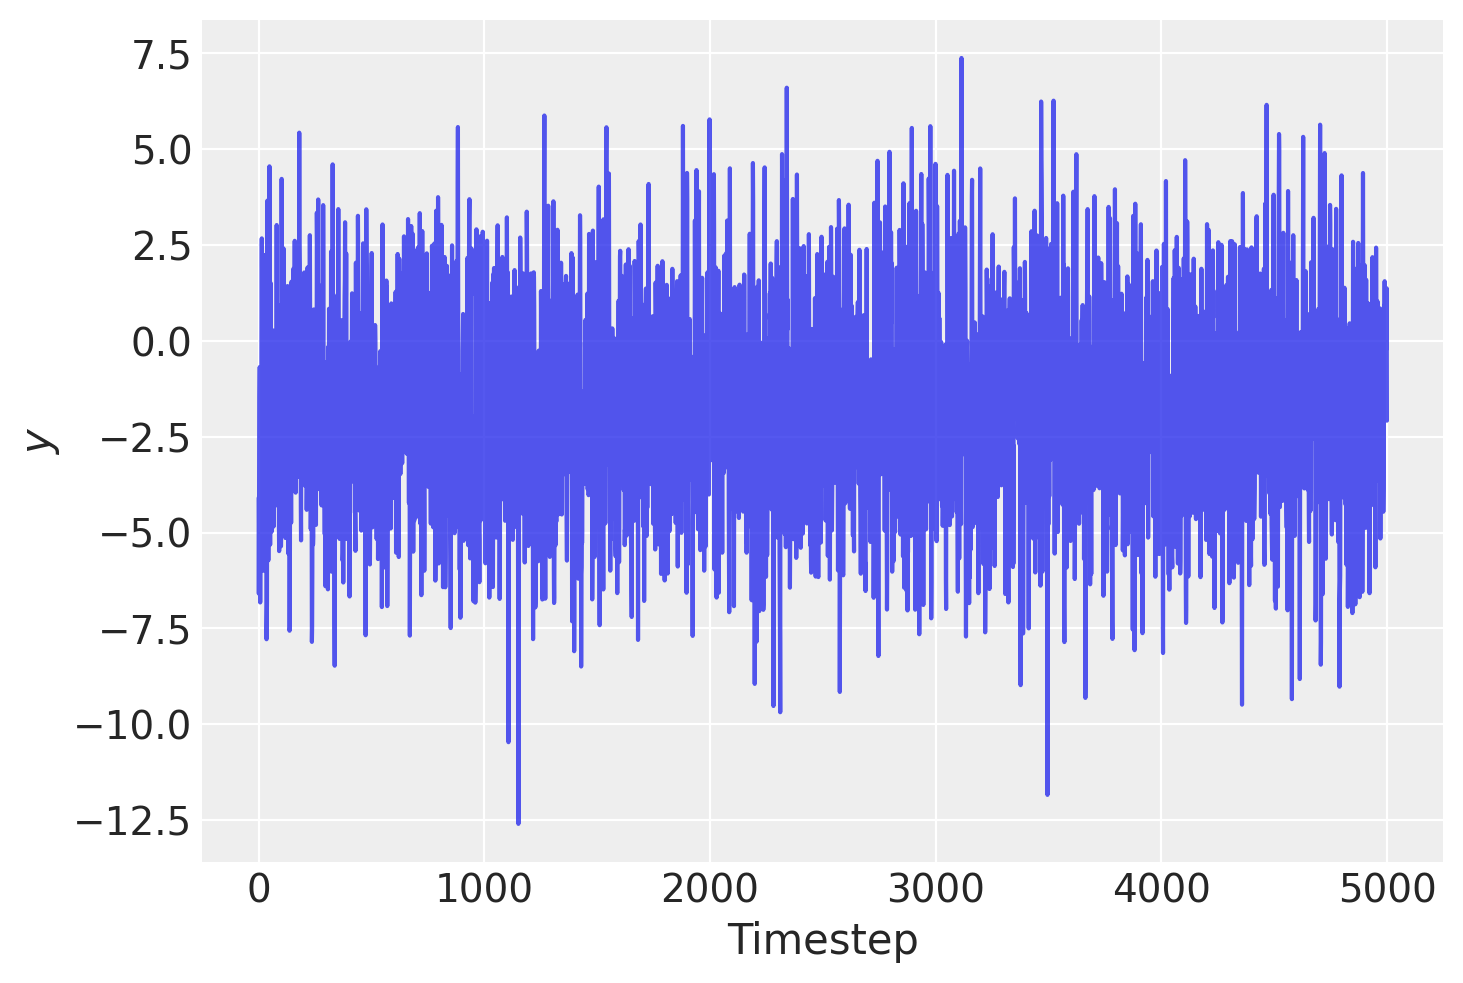

In [4]:
T = 10000

# true stationarity:
true_rho = 0.7, -0.3
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = -1.0

y = np.random.normal(loc=true_center, scale=true_sigma, size=T)
y[1] += true_rho[0] * y[0]
for t in range(2, T - 100):
    y[t] += true_rho[0] * y[t - 1] + true_rho[1] * y[t - 2]

y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

In [5]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=1.0, shape=2)
    # precision of the innovation term
    tau = pm.Exponential("tau", lam=0.5)

    likelihood = pm.AR(
        "y", rho=rho, tau=tau, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rho, tau]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


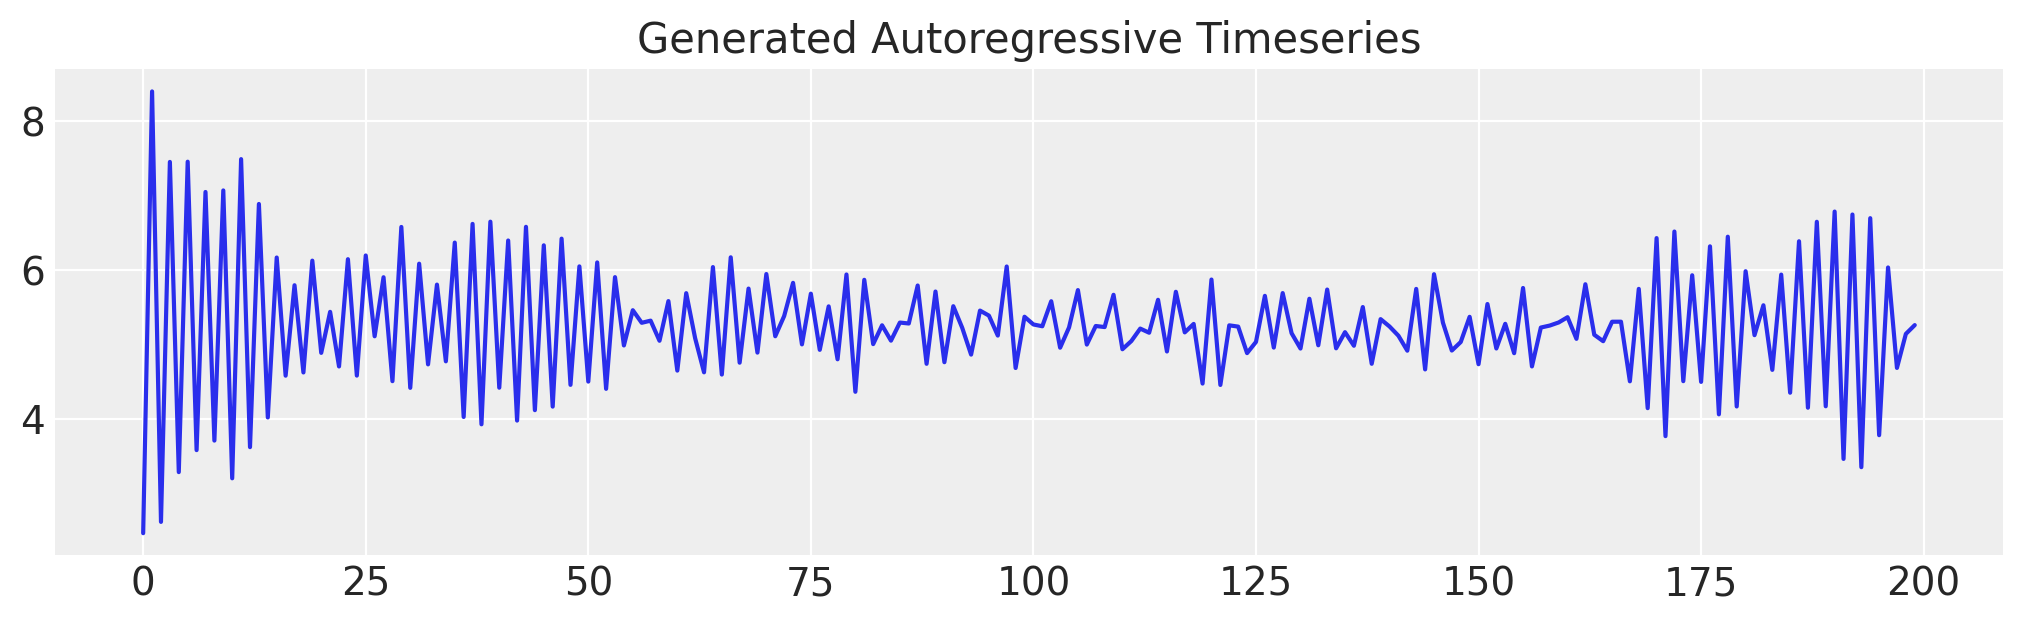

In [6]:
def simulate_ar(intercept, coef1, coef2, noise=0.3, *, warmup=10, steps=200):
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup + steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup + steps):
        draws[step] = (
            intercept
            + coef1 * draws[step - 1]
            + coef2 * draws[step - 2]
            + np.random.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]


# True parameters of the AR process
ar1_data = simulate_ar(10, -0.9, 0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Generated Autoregressive Timeseries", fontsize=15)
ax.plot(ar1_data);

In [7]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.
priors = {
    "coefs": {"mu": [10, 0.2], "sigma": [0.1, 0.1], "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, sigma, ar]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 66 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]
